Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import azureml.core
from azureml.core import Workspace
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException
import os

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.27.0


In [3]:
project_folder=os.getcwd()
train_data_folder='trainDataset'
test_data_folder='testDataset'
script_folder = os.path.join(os.getcwd(), "scripts")
#script_folder=project_folder # for now I keep the scripts in the main folder
os.makedirs(script_folder, exist_ok=True)

### Connect to workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **config.json** and loads the details into an object named `ws`.

In [5]:
# load workspace configuration from the config.json file in the current folder.
ws = Workspace.from_config()
ws = Workspace(subscription_id='ed940d3a-1d48-4740-b2cb-bd9fe6642e7b' ,resource_group='20191107_DNNhyperdrive', workspace_name = 'WS1' )

ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)
print(ws.name, ws.location, ws.resource_group, ws.location, sep='\t')

AzureBlob ws11078562529 azureml-blobstore-15002b44-9629-4d8c-a66d-71dde33561ab
WS1	westeurope	20191107_DNNhyperdrive	westeurope


### Create experiment

Create an experiment to track the runs in your workspace. A workspace can have muliple experiments. 

In [6]:
experiment_name = 'ImageClassifierhyperdrive'

from azureml.core import Experiment
experiment = Experiment(workspace=ws, name=experiment_name)

### Create or Attach existing compute resource
By using Azure Machine Learning Compute, a managed service, data scientists can train machine learning models on clusters of Azure virtual machines. Examples include VMs with GPU support. In this tutorial, you create Azure Machine Learning Compute as your training environment. The code below creates the compute clusters for you if they don't already exist in your workspace.

**Creation of compute takes approximately 5 minutes.** If the AmlCompute with that name is already in your workspace the code will skip the creation process.

In [7]:
cluster_name = "gpu-cluster"

try:
    compute_target = ComputeTarget(workspace=ws, name=cluster_name)
    print('Found existing compute target')
except ComputeTargetException:
    print('Creating a new compute target...')
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_NC6',
                                                           min_nodes=0,
                                                           max_nodes=4)

    compute_target = ComputeTarget.create(ws, cluster_name, compute_config)

    compute_target.wait_for_completion(show_output=True, min_node_count=None, timeout_in_minutes=20)

Found existing compute target


In [8]:
with open(os.path.join('trainDataset', "x_train.tsv"),"rb") as f:
     x_train=pickle.load(f)
with open(os.path.join('trainDataset', "y_train.tsv"),"rb") as f:
     y_train=pickle.load(f)
with open(os.path.join('trainDataset', "x_val.tsv"),"rb") as f:
     x_val=pickle.load(f)
with open(os.path.join('trainDataset', "y_val.tsv"),"rb") as f:
     y_val=pickle.load(f)

with open(os.path.join('testDataset', "x_test.tsv"),"rb") as f:
     x_test=pickle.load(f)
with open(os.path.join('testDataset', "y_test.tsv"),"rb") as f:
     y_test=pickle.load(f)

In [9]:
with open(os.path.join('trainDataset', "encoder"),"rb") as f:
     encoder=pickle.load(f)

### Preparation for the model

In [10]:
ntrain=len(x_train)
nval=len(x_val)
batch_size=32

In [11]:
print(x_train.shape)
print(y_train.shape)

(1025, 150, 150, 3)
(1025, 8)


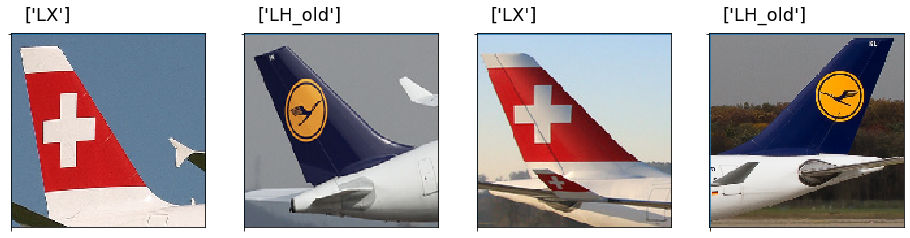

In [12]:
count = 0
sample_size = 4
plt.figure(figsize = (16, 6))
for i in np.random.permutation(x_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 10, y = -10, s = encoder.inverse_transform([np.argmax(y_train[i])]), fontsize = 18)
    #plt.imshow(x_train[i][:,:,0].reshape(150,-1), cmap = plt.cm.Greys)
    plt.imshow(x_train[i])
plt.show()

## Datasets

In [13]:
from azureml.core import Dataset
trainDataset = Dataset.get_by_name(ws,'trainDataset')
testDataset = Dataset.get_by_name(ws,'testDataset')

## Define Environment

In [24]:
from azureml.core import Environment
keras_env = Environment.get(ws, 'keras-env', version=None, label=None)

## Configure the job 

In [26]:
from azureml.core.runconfig import DockerConfiguration
dc=DockerConfiguration(use_docker=True, shared_volumes=True, arguments=[], shm_size='2g')

1. Without hyperdrive

In [27]:
from azureml.core import ScriptRunConfig

args = ['--data-folder', trainDataset.as_named_input('trainDataset').as_mount(),
        '--batch-size', 64,
      #  '--layer-size', 1,
        '--learning-rate', 0.001]

src = ScriptRunConfig(source_directory=script_folder,
                      script='train.py',
                      arguments=args,
                      compute_target=compute_target,
                      environment=keras_env,
                      docker_runtime_config=dc)

In [28]:
from azureml.widgets import RunDetails
run = experiment.submit(src)
RunDetails(run).show()

_UserRunWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO', 's…

# With Hyperdrive

In [39]:
import azureml.train.hyperdrive.HyperDriveRunConfig

ImportError: cannot import name '_update_args_and_inputs' from 'azureml.core.script_run_config' (C:\Users\ankubasi\AppData\Local\Continuum\anaconda3\envs\mlenv37\lib\site-packages\azureml\core\script_run_config.py)

In [36]:
from azureml.core import ScriptRunConfig
from azureml.train.hyperdrive import RandomParameterSampling, BanditPolicy, HyperDriveConfig, PrimaryMetricGoal

ImportError: cannot import name '_update_args_and_inputs' from 'azureml.core.script_run_config' (C:\Users\ankubasi\AppData\Local\Continuum\anaconda3\envs\mlenv37\lib\site-packages\azureml\core\script_run_config.py)

In [30]:

from azureml.train.hyperdrive import choice, uniform



ps = RandomParameterSampling(
    {
        '--batch-size': choice(32,64, 128),
        '--learning-rate': uniform(1e-4, 1e-3),
        '--layer-size': choice(1,2,4)
    }
)


args = ['--data-folder', trainDataset.as_named_input('trainDataset').as_mount()]

src = ScriptRunConfig(source_directory=script_folder,
                      script='train.py',
                      arguments=args,
                      compute_target=compute_target,
                      environment=keras_env,
                      docker_runtime_config=dc)

policy = BanditPolicy(evaluation_interval=2, slack_factor=0.1)


ImportError: cannot import name '_update_args_and_inputs' from 'azureml.core.script_run_config' (C:\Users\ankubasi\AppData\Local\Continuum\anaconda3\envs\mlenv37\lib\site-packages\azureml\core\script_run_config.py)

In [ ]:
hdc = HyperDriveConfig(run_config=src, 
                       hyperparameter_sampling=ps, 
                       policy=policy, 
                       primary_metric_name='validation_acc', 
                       primary_metric_goal=PrimaryMetricGoal.MAXIMIZE, 
                       max_total_runs=8,
                       max_concurrent_runs=4)

### Submit the job to the cluster

Run the experiment by submitting the estimator object. And you can navigate to Azure portal to monitor the run.

In [ ]:
%%writefile .amlignore
data
model
sourceData
Training
Testing
trainDataset
testDataset
dataLH
model_keras.h5
model_weights.h5
model_wieghts.h5
ARCH

Writing .amlignore


In [ ]:
run = experiment.submit(config=hdc)
run

Experiment,Id,Type,Status,Details Page,Docs Page
ImageClassifierhyperdrive,HD_b3926e57-3971-4e32-a5b9-32190be41b8a,hyperdrive,Running,Link to Azure Machine Learning studio,Link to Documentation


## Monitor a remote run


In [ ]:
from azureml.widgets import RunDetails
RunDetails(run).show()


_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO',…

### register model from best run

In [ ]:
best_run = run.get_best_run_by_primary_metric()
model = best_run.register_model(model_name='kerasmodel', model_path="outputs/model")

print(model.name, model.id, model.version, sep = '\t')

onnxmodel	onnxmodel:6	6


![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/MachineLearningNotebooks/tutorials/img-classification-part1-training.png)

# Deploy

In [ ]:
%%writefile score.py

import json
import numpy as np
from azureml.core.model import Model
import onnxruntime as rt

def init():
    global session
    model_path = Model.get_model_path(model_name='onnxmodel')
    session = rt.InferenceSession(model_path)


def run(raw_data):
    data = np.array(json.loads(raw_data)['data'])
    data = data.astype(np.float32)
    input_name = session.get_inputs()[0].name
    
    # make prediction
    res = session.run(None, {input_name: data})
    prob = res[0]

    return prob.tolist()

Overwriting score.py


### Serve model

===========================================================













==============================================================

In [ ]:
from azureml.core.conda_dependencies import CondaDependencies 

myenv = CondaDependencies.create(pip_packages=["numpy","onnxruntime","azureml-defaults"]
                                )
myenv.add_conda_package('tensorflow')
myenv.add_conda_package('keras')
with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

In [ ]:
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(runtime="python",
                                   entry_script="score.py",
                                   conda_file="myenv.yml")

In [ ]:
from azureml.core.webservice import  LocalWebservice  #                  <---------- LOCAL DEPLOYMENT IS MUCH FASTER
from azureml.core.model import Model

deployment_config = LocalWebservice.deploy_configuration()
service = Model.deploy(ws, "hyperdrivedservice", [model], inference_config, deployment_config)
service.wait_for_deployment(show_output = True)
print(service.state)

Generating Docker build context.
Package creation Succeeded
Package creation Succeeded
Logging into Docker registry demoimages64d1b10b.azurecr.io
Building Docker image from Dockerfile...
Step 1/5 : FROM demoimages64d1b10b.azurecr.io/azureml/azureml_9addd638380b11aeec1f6735cb271a72
 ---> 073624575c6f
Step 2/5 : COPY azureml-app /var/azureml-app
 ---> a16e89f00860
Step 3/5 : COPY model_config_map.json /var/azureml-app/model_config_map.json
 ---> d77877f459af
Step 4/5 : RUN mv '/var/azureml-app/tmpuaq4r7hq.py' /var/azureml-app/main.py
 ---> Running in bd3c8ccc2f3e
 ---> 7554f55666f8
Step 5/5 : CMD ["runsvdir","/var/runit"]
 ---> Running in e6e905ab4ff8
 ---> 0079939374f3
Successfully built 0079939374f3
Successfully tagged hyperdrivedservice:latest
Starting Docker container...
Docker container running.
Checking container health...
Local webservice is running at http://localhost:32773
running


===========================================================













==============================================================

In [ ]:
with open(os.path.join('testDataset', "x_test.tsv"),"rb") as f:
     x_test=pickle.load(f)
        
import json

idx=3
test_sample_x=x_test[idx]
test_sample_y=y_test[idx]


testx=np.expand_dims(test_sample_x, axis=0)
testxy=test_sample_y

print(testx.shape)
test_sample=json.dumps({'data':testx.tolist()})

(1, 150, 150, 3)


In [ ]:
import requests

# create the required header
headers = {'Content-Type':'application/json'}
print('calling ', service.scoring_uri)
# post the request to the service and display the result
resp = requests.post(service.scoring_uri, test_sample, headers = headers)
print(resp.text)
output  = resp.text

calling  http://localhost:32770/score
[[0.9998139142990112, 0.0, 2.9802322387695312e-08, 0.0, 0.0, 2.9802322387695312e-08, 0.005098700523376465, 5.081295967102051e-05]]


In [ ]:
def Convert(InputString): 
    string= InputString.replace('[','')
    string= string.replace(']','')
    string=string.replace(' ', '')
    li = list(string.split(",")) 
    return li 
  

In [ ]:
result=np.array(Convert(output))
result=pd.DataFrame(np.around(result.astype(np.float),2),columns=['predicted'])
result['MaxVal']=''
MostProbable=result.predicted.idxmax()
result['MaxVal'][MostProbable]= ' *'
result


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,predicted,MaxVal
0,1.00,*
1,0.00,
2,0.00,
3,0.00,
4,0.00,
5,0.00,
6,0.01,
7,0.00,


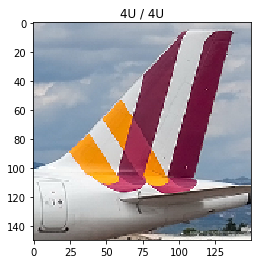

In [ ]:
plt.figure()
labelsValid=np.core.defchararray.add(np.core.defchararray.add(test_sample_y,' / '),predictedLabel[0])

title_obj=plt.title(labelsValid, fontsize=12)
if (predictedLabel[0]!=test_sample_y):
        plt.setp(title_obj, color='r') 
plt.imshow(test_sample_x)